<a href="https://colab.research.google.com/github/shirish-baral/deep-learning/blob/main/U_net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

**Basic Implementation**

In [ ]:
import torch
import torch.nn as nn


In [ ]:
class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, features=[64, 128, 256, 512]):
        super(UNet, self).__init__()
        self.encoder = nn.ModuleList()
        self.decoder = nn.ModuleList()

        # Encoder
        for feature in features:
            self.encoder.append(self._block(in_channels, feature))
            in_channels = feature

        # Decoder
        for feature in reversed(features):
            self.decoder.append(
                nn.ConvTranspose2d(feature * 2, feature, kernel_size=2, stride=2)
            )
            self.decoder.append(self._block(feature * 2, feature))

        self.bottleneck = self._block(features[-1], features[-1] * 2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        # Encoder path with skip connections
        for down in self.encoder:
            x = down(x)
            skip_connections.append(x)
            x = nn.MaxPool2d(kernel_size=2, stride=2)(x)

        # Bottleneck
        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]  # reverse for decoding

        # Decoder path with upsampling and skip connections
        for idx in range(0, len(self.decoder), 2):
            x = self.decoder[idx](x)  # upsample
            skip_connection = skip_connections[idx // 2]

            # Match size (in case of mismatch due to padding)
            if x.shape != skip_connection.shape:
                x = torch.nn.functional.interpolate(x, size=skip_connection.shape[2:])

            x = torch.cat((skip_connection, x), dim=1)  # concat along channel dimension
            x = self.decoder[idx + 1](x)

        return self.final_conv(x)

    def _block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True),
        )


In [ ]:
# Instantiate model and test with dummy input
if __name__ == "__main__":
    model = UNet(in_channels=1, out_channels=1)
    x = torch.randn((1, 1, 572, 572))  # Example input size
    out = model(x)
    print("Output shape:", out.shape)


Output shape: torch.Size([1, 1, 572, 572])


# **U-Net in PyTorch, using the Oxford Pets Segmentation Dataset**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
from torchvision.datasets import OxfordIIITPet
from torchvision.transforms import functional as TF
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np


**U-Net class**

In [ ]:
class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, features=[64, 128, 256, 512]):
        super(UNet, self).__init__()
        self.encoder = nn.ModuleList()
        self.decoder = nn.ModuleList()

        # Encoder
        for feature in features:
            self.encoder.append(self._block(in_channels, feature))
            in_channels = feature

        # Decoder
        for feature in reversed(features):
            self.decoder.append(
                nn.ConvTranspose2d(feature * 2, feature, kernel_size=2, stride=2)
            )
            self.decoder.append(self._block(feature * 2, feature))

        self.bottleneck = self._block(features[-1], features[-1] * 2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        # Encoder path with skip connections
        for down in self.encoder:
            x = down(x)
            skip_connections.append(x)
            x = nn.MaxPool2d(kernel_size=2, stride=2)(x)

        # Bottleneck
        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]  # reverse for decoding

        # Decoder path with upsampling and skip connections
        for idx in range(0, len(self.decoder), 2):
            x = self.decoder[idx](x)  # upsample
            skip_connection = skip_connections[idx // 2]

            # Match size (in case of mismatch due to padding)
            if x.shape != skip_connection.shape:
                x = torch.nn.functional.interpolate(x, size=skip_connection.shape[2:])

            x = torch.cat((skip_connection, x), dim=1)  # concat along channel dimension
            x = self.decoder[idx + 1](x)

        return self.final_conv(x)

    def _block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True),
        )


**Custom Dataset Wrapper for Segmentation**

In [ ]:
class OxfordPetDataset(Dataset):
    def __init__(self, root, image_set='train', transform=None):
        self.dataset = OxfordIIITPet(
            root=root,
            download=True,
            target_types="segmentation",
            transform=None,
            target_transform=None
        )
        self.transform = transform
        self.image_set = image_set
        self.indices = list(range(len(self.dataset)))
        if self.image_set == 'train':
            self.indices = self.indices[:int(0.8 * len(self.dataset))]
        else:
            self.indices = self.indices[int(0.8 * len(self.dataset)):]

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        image, mask = self.dataset[self.indices[idx]]

        # Convert mask to binary foreground-background mask
        mask = np.array(mask)
        mask = torch.tensor((mask > 1).astype(np.float32))  # 1 for pet, 0 for background

        # Apply same transform to image and mask
        image = TF.to_tensor(image)
        image = TF.resize(image, (128, 128))
        mask = TF.resize(mask.unsqueeze(0), (128, 128)).squeeze(0)

        return image, mask


In [ ]:
# Load Data
train_dataset = OxfordPetDataset(root="./data", image_set='train')
val_dataset = OxfordPetDataset(root="./data", image_set='val')

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4)


100%|██████████| 792M/792M [07:10<00:00, 1.84MB/s] 
100%|██████████| 19.2M/19.2M [00:18<00:00, 1.01MB/s]


**Training Loop**

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(in_channels=3, out_channels=1).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

def train(model, loader):
    model.train()
    total_loss = 0
    for images, masks in loader:
        images, masks = images.to(device), masks.to(device).unsqueeze(1)

        outputs = model(images)
        loss = criterion(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    return total_loss / len(loader)

def evaluate(model, loader):
    model.eval()
    with torch.no_grad():
        for images, masks in loader:
            images, masks = images.to(device), masks.to(device).unsqueeze(1)
            outputs = torch.sigmoid(model(images))
            return images[0].cpu(), masks[0].cpu(), outputs[0].cpu()


**Train for Epochs**

In [ ]:
number = 10
for epoch in range(number):
    loss = train(model, train_loader)
    print(f"Epoch {epoch+1} - Loss: {loss:.4f}")


Epoch 1 - Loss: 0.3001
Epoch 2 - Loss: 0.2741
Epoch 3 - Loss: 0.2563
Epoch 4 - Loss: 0.2366
Epoch 5 - Loss: 0.2137
Epoch 6 - Loss: 0.2034
Epoch 7 - Loss: 0.1887
Epoch 8 - Loss: 0.1697
Epoch 9 - Loss: 0.1549
Epoch 10 - Loss: 0.1464


# Visualize Predictions

In [ ]:
def visualize(image, mask, prediction):
    import matplotlib.pyplot as plt
    import numpy as np

    # Ensure everything is on CPU and in numpy format
    image_np = image.permute(1, 2, 0).clamp(0, 1).cpu().numpy()
    mask_np = mask.squeeze().cpu().numpy()
    pred_np = (prediction.squeeze() > 0.5).cpu().numpy()

    # Print debug info
    print("Image shape:", image_np.shape, "| min:", image_np.min(), "| max:", image_np.max())
    print("Mask unique values:", np.unique(mask_np))
    print("Prediction min:", pred_np.min(), "| max:", pred_np.max())

    # Plotting
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    axs[0].imshow(image_np)
    axs[0].set_title("Input Image")
    axs[0].axis("off")

    axs[1].imshow(mask_np, cmap="gray")
    axs[1].set_title("Ground Truth Mask")
    axs[1].axis("off")

    axs[2].imshow(pred_np, cmap="gray")
    axs[2].set_title("Predicted Mask")
    axs[2].axis("off")

    plt.tight_layout()
    plt.show()


Image shape: (128, 128, 3) | min: 0.0 | max: 0.9836544
Mask unique values: [0.00000000e+00 5.92537763e-05 2.63150549e-04 2.84140988e-04
 4.55381058e-04 4.55381087e-04 4.55381116e-04 5.35156869e-04
 7.95503496e-04 8.15198116e-04 8.24431190e-04 1.17715821e-03
 1.22334994e-03 1.58587494e-03 1.75210880e-03 1.78463280e-03
 2.38231197e-03 2.50315340e-03 2.60206661e-03 2.64545740e-03
 2.67084362e-03 2.74670240e-03 2.81388918e-03 3.22100474e-03
 3.31172207e-03 3.31498752e-03 3.53894150e-03 4.51034307e-03
 4.61135106e-03 5.29697910e-03 5.41549316e-03 5.53285563e-03
 6.73261937e-03 6.83386624e-03 7.41495192e-03 7.47249648e-03
 7.57944630e-03 7.78100407e-03 8.57301988e-03 8.92970152e-03
 1.00233443e-02 1.00653367e-02 1.01017272e-02 1.02510294e-02
 1.12144677e-02 1.15168458e-02 1.24238506e-02 1.24910437e-02
 1.39495526e-02 1.48686897e-02 1.50273331e-02 1.50273340e-02
 1.53095983e-02 1.63831897e-02 2.04288177e-02 2.04918012e-02
 2.04918031e-02 2.04918049e-02 2.04918068e-02 2.04918087e-02
 2.1002721

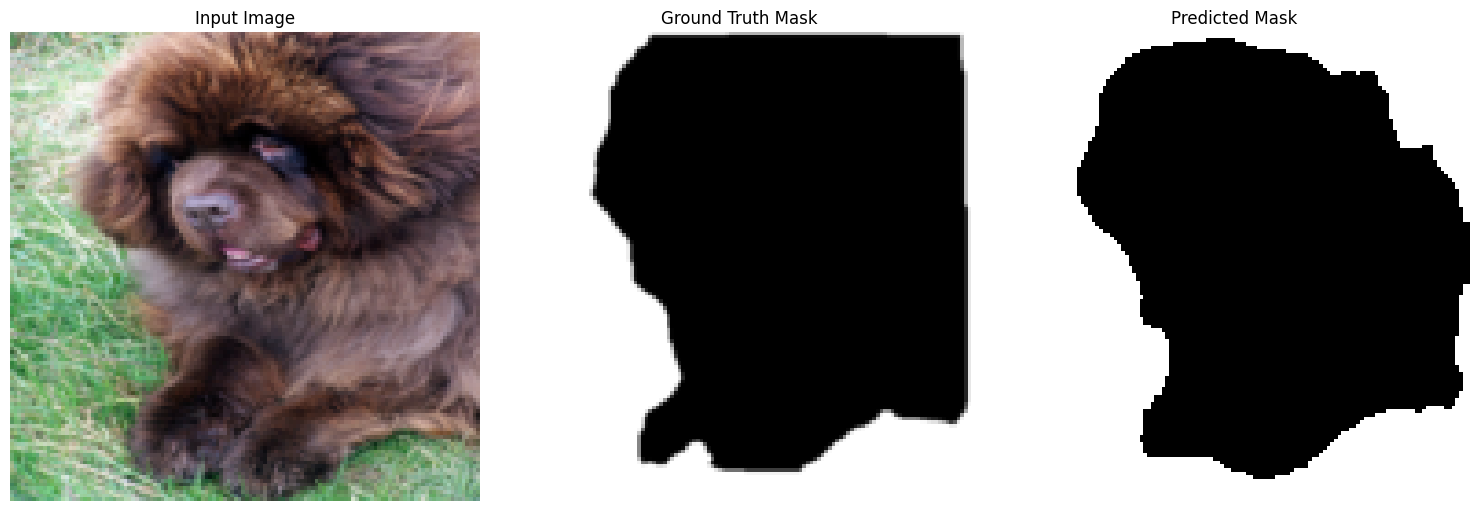

In [ ]:
image, mask, prediction = evaluate(model, val_loader)
visualize(image, mask, prediction)